# Problem: 
In the context of industrial processes, the optimization of heat exchange networks is crucial for enhancing energy efficiency, reducing operational costs, and minimizing environmental impact.

In this project, a heat exchanger network designed for a specific situation is considered. You can see the visual of this network below. For this HEN, we will try to find the minimum dT value that provides the most optimal cost.

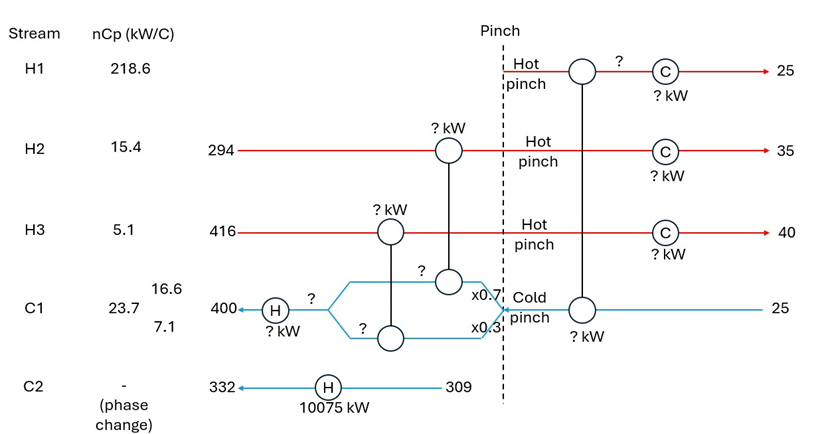

The input must necessarily include a value representing either the hot or cold utility, denoted as 'H/C'. It should be in the form of 'H{number}' for hot utility and 'C{number}' for cold utility. Values for n, Cp, and nCp must be entered. If there is a phase change, the energy required for this phase transition must be entered. If there is no phase change, it must be left blank. Tin and Tout values must be entered in Celsius degrees.

![alt text](image-2.png)

Initially, the cost calculation will be done for a specific dT value. Then, this will be functionalized and optimized.

The necessary libraries are being added. Pandas and Numpy will be sufficient.

In [1]:
#Libraries that used
import pandas as pd
import numpy as np

The input data is being read as a dataframe. The dataframe needs to be separated into hot and cold based on its name.

In [2]:
# Data
df = pd.read_excel("heatForPython.xlsx")

data_frame_cold = df[df['H/C'].str.contains('C')]
data_frame_hot = df[df['H/C'].str.contains('H')]

The dT_min value is entered here as 30. It will be assigned as a variable later.

In [3]:
#dT
dT = 30

The Temperature Interval Method will require endpoints to find the hot and cold utilities. The hot and cold endpoints are being identified separately for possible future developments.

In [4]:
#End Points
def endPointMaker(data, type='C'):
    temperatures = pd.concat([data['Tin'], data['Tout']])
    unique_sorted_temperatures = np.sort(temperatures.unique())
    dataFrame = pd.DataFrame(unique_sorted_temperatures, columns=[f'{type} end Points'])
    return dataFrame

cold_end_point = endPointMaker(data_frame_cold, 'C')
hot_end_point = endPointMaker(data_frame_hot, 'H')

Pseudo endpoints are found using the hot and cold endpoints. 
(equation from sinott page 130.)

In [5]:
'''Pseudo end points'''
pseudo_cold_end_points= cold_end_point + dT/2
pseudo_hot_end_points= hot_end_point - dT/2

The mergeAndSortEndpoints function is written to merge and sort the hot and cold endpoints. It is later used to merge and sort both pseudo and normal temperatures.

In [6]:
def mergeAndSortEndpoints(cold_end_points, hot_end_points):
    merged = pd.concat([cold_end_points, hot_end_points]).reset_index(drop=True)
    merged = merged.drop_duplicates().sort_values(by=merged.columns[0]).reset_index(drop=True)
    combined_temperatures = pd.concat([merged['C end Points'], merged['H end Points']]).dropna()
    unique_sorted_temperatures = combined_temperatures.drop_duplicates().sort_values(ascending=False).reset_index(drop=True)
    return unique_sorted_temperatures

'''Total End Points'''
total_end_points = mergeAndSortEndpoints(cold_end_point, hot_end_point)
'''Pseudo Total End Points'''
total_pseudo_end_points = mergeAndSortEndpoints(pseudo_cold_end_points, pseudo_hot_end_points)

In [7]:
total_end_points

0    416.041733
1    400.000000
2    332.000000
3    309.000000
4    294.074895
5    170.000000
6     40.000000
7     35.000000
8     25.000000
dtype: float64

The presence of a phase change in a stream causes some uncertainties in calculating the heat it emits. If a stream with a phase change is between two time intervals written using mergeAndSortEndpoints, we can say that this energy calculation will definitely not cause any problems. This aspect is very important for the future of the code. Whether a stream with a phase change is between two intervals can be checked, and different calculations can be added later on.

In [8]:
# Phase change end point check
def check_phase_change(df, temperature_list):
    # temperature_list'teki tüm değerleri float'a dönüştür
    temperature_list = [float(temp) for temp in temperature_list]  
    # 'phase change' değeri NaN olmayan satırları filtrele
    filtered_df = df.dropna(subset=['phase change'])
    # Filtrelenmiş satırları döngüye al
    for index, row in filtered_df.iterrows():
        tin = float(row['Tin'])
        tout = float(row['Tout'])        
        # Her iki değerin de listede olup olmadığını kontrol et
        if tin in temperature_list and tout in temperature_list:
            tin_index = temperature_list.index(tin)
            tout_index = temperature_list.index(tout)
        
            # Tin ve Tout'un listede sıralı olup olmadığını kontrol et
            if abs(tin_index - tout_index) == 1:
                return True 
            else:
                print(f"Tin ({tin}) ve Tout ({tout}) listede yan yana değil.")
        else:
            return False

In [9]:
check_phase_change(df, total_end_points)

True

Pseudo temperatures are added to dataframe. The merged and sorted temperature intervals of pseudo temperatures are found.

In [10]:
# Pinch Point,  Hot and Cold  Utulity
# Data frame'e pseudo sıcaklıkları ekleme

df['Pseudo Tin'] = df.apply(lambda row: row['Tin'] + dT/2 if 'C' in row['H/C'] else row['Tin'] - dT/2, axis=1)
df['Pseudo Tout'] = df.apply(lambda row: row['Tout'] + dT/2 if 'C' in row['H/C'] else row['Tout'] - dT/2, axis=1)


intervals = zip(total_pseudo_end_points, total_pseudo_end_points[1:])


First, the streams corresponding to the temperature intervals are identified.

![Grid Diagram](image.png)

If there is a phase change, the phase change energy is used for that interval. If there is no phase change, the nCp value is summed with the interval temperature range. Energy values are added for hot utilities, while they are subtracted for cold utilities, and the cumulative value is kept in a list.

In [11]:
negative_dH = []
# Aralıklar üzerinde döngü
for upper, lower in intervals:
    '''ARALIKLAR'''
    # Mask kullanarak DataFrame'den verileri filtreleme
    # 'H' ile başlayanlar için mask
    mask_H = ((df['H/C'].str.startswith('H')) &
            ((df['Pseudo Tin'] >= upper) & (df['Pseudo Tout'] <= lower)))

    # 'C' ile başlayanlar için mask
    mask_C = ((df['H/C'].str.startswith('C')) &
            ((df['Pseudo Tin'] <= lower) & (df['Pseudo Tout'] >= upper)))

    # 'H' ile başlayanlar için seçilen akımlar
    selected_streams_H = df[mask_H]

    # 'C' ile başlayanlar için seçilen akımlar
    selected_streams_C = df[mask_C]
    selected_streams = pd.concat([selected_streams_H, selected_streams_C], ignore_index=True)

    '''-dH BULMAK İÇİN'''
    total_energy = 0
    for _, stream in selected_streams.iterrows():
        if stream['H/C'].startswith('H'):
            if pd.notna(stream['phase change']):
                total_energy += stream['q (kj/s)']
            else:
                total_energy += stream['nCp (kJ/s-K)'] * (upper - lower)
        else: 
            if pd.notna(stream['phase change']):
                total_energy -= stream['q (kj/s)']
            else:
                total_energy -= stream['nCp (kJ/s-K)'] * (upper - lower)
    negative_dH.append(total_energy)

In [12]:
negative_dH

[-330.7360451301091,
 -1007.2759513804625,
 -10504.154938149159,
 -837.3524556671528,
 -399.6290605395793,
 24765.78657519922,
 3585.739526882979,
 1169.9675968210875,
 2185.7553550391626]

Starting with zero, the smallest value in the negative_dH list gives us the minimum hot utility. Starting with the minimum hot utility, the final value of the cumulative list gives the cold utility.


![alt text](image-3.png)

In [13]:
cumulative_energy_list= []
energy_start=0
for energy in negative_dH:
    energy_start += energy
    cumulative_energy_list.append(energy_start)

min_hot_utulity= -min(cumulative_energy_list)

cumulative_energy_list_start_with_hot_utility = []
cumulative_energy_list_start_with_hot_utility.append(min_hot_utulity)
energy_start=min_hot_utulity
for energy in negative_dH:
    energy_start += energy
    cumulative_energy_list_start_with_hot_utility.append(energy_start)
min_cold_utulity= cumulative_energy_list_start_with_hot_utility[-1]
print(f'Minimum cold utility : {min_cold_utulity}, Minimum hot utilility : {min_hot_utulity}')

Minimum cold utility : 31707.24905394245, Minimum hot utilility : 13079.148450866462


 Another importance of this cumulative list is that the index of the value zero and the index of the pinch point are the same. So the cold pich point and hot pich point is easily obtained.

In [14]:
'''/////  Pinch Points /////'''
# pinch point for hot
pinch_indeks = np.abs(cumulative_energy_list_start_with_hot_utility).argmin()
hot_pinch = total_pseudo_end_points [pinch_indeks] + dT/2
# pinch point for cold
cold_pinch = total_pseudo_end_points [pinch_indeks] - dT/2

print(f'Hot Pinch Temperature : {hot_pinch}, Cold Pinch Temperature : {cold_pinch}')

Hot Pinch Temperature : 170.0, Cold Pinch Temperature : 140.0


In this part, a new dataset is being established for the HEN. Some variables are taken from the previous dataframe, while others are entered at this stage.

In [15]:
split_fraction = 0.7
exchanger_data = {
    'Heat exchanger' :  ["H1-C1", "H1-CU", "H2-CU", "H3-CU", "H2-C1/1", "H3-C1/2", "C1-HU", "C2-HU"],
    "H": ["H1", "H1", "H2", "H3", "H2", "H3","fh", "hps" ],
    "C": ["C1", "cw", "cw", "cw", "C1/1", "C1/2", "C1", "C2"],
    "nCp(h)": [float(df[df['H/C'].str.contains('H1')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H1')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H2')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H3')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H2')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H3')]['nCp (kJ/s-K)']), np.nan, np.nan],
    "nCp (c)": [float(df[df['H/C'].str.contains('C1')]['nCp (kJ/s-K)']) , np.nan, np.nan, np.nan, float(df[df['H/C'].str.contains('C1')]['nCp (kJ/s-K)']) *split_fraction , float(df[df['H/C'].str.contains('C1')]['nCp (kJ/s-K)']) * (1- split_fraction) , float(df[df['H/C'].str.contains('C1')]['nCp (kJ/s-K)']) , np.nan],
    "T(h,in)": [hot_pinch, 'a' , hot_pinch, hot_pinch, float(df[df['H/C'].str.contains('H2')]['Tin']), float(df[df['H/C'].str.contains('H3')]['Tin']), 450, 370],
    "T(h,out)": ["a", float(df[df['H/C'].str.contains('H1')]['Tout']), float(df[df['H/C'].str.contains('H2')]['Tout']), float(df[df['H/C'].str.contains('H3')]['Tout']), hot_pinch,  hot_pinch, 350, 350],
    "T(c,in)": [float(df[df['H/C'].str.contains('C1')]['Tin']), 20, 20, 20, cold_pinch, cold_pinch, "#DEĞER!", float(df[df['H/C'].str.contains('C2')]['Tin'])],
    "T(c,out)": [cold_pinch, 45, 40, 30, "b", "c", float(df[df['H/C'].str.contains('C1')]['Tout']), float(df[df['H/C'].str.contains('C2')]['Tout'])],
    "Q": ["q1", "q2", "q3", "q4", "q5", "q6", "q7", float(df[df['H/C'].str.contains('C2')]['q (kj/s)'])],
    'U' : [ (((427.8+2713.2)/(2*3600)) ),(((2713.2+13500)/(2*3600))) , (((1085.5+13500)/(2*3600))) , (((427.8+ 13500)/(2*3600)))  ,(((1085.5+2713.2)/(2*3600))) ,((( 427.8+2713.2)/(2*3600))) , (((2713.2+ 399.6)/(2*3600))) , (((775.8+21600)/(2*3600)))  ]
}


Missing data in the dataset are calculated step by step.

In [16]:
''' Eksik dataların girişi'''
exchanger_data['Q'][0] = (exchanger_data['T(c,out)'][0]  - exchanger_data['T(c,in)'][0]) * exchanger_data['nCp (c)'][0]
exchanger_data['T(h,out)'][0] = (- exchanger_data['Q'][0])/ exchanger_data['nCp(h)'][0] + exchanger_data['T(h,in)'][0]
exchanger_data['T(h,in)'][1]  = exchanger_data['T(h,out)'][0]
exchanger_data['Q'][1] =  (exchanger_data['T(h,in)'][1]  - exchanger_data['T(h,out)'][1]) * exchanger_data['nCp(h)'][1]
exchanger_data['Q'][2] = (exchanger_data['T(h,in)'][2]  - exchanger_data['T(h,out)'][2]) * exchanger_data['nCp(h)'][2]
exchanger_data['Q'][3] = (exchanger_data['T(h,in)'][3]  - exchanger_data['T(h,out)'][3]) * exchanger_data['nCp(h)'][3]
exchanger_data['Q'][4] = (exchanger_data['T(h,in)'][4]  - exchanger_data['T(h,out)'][4]) * exchanger_data['nCp(h)'][4]
exchanger_data['T(c,out)'][4] = exchanger_data['Q'][4] / exchanger_data['nCp (c)'][4]  + exchanger_data['T(c,in)'][4]
exchanger_data['Q'][5] = (exchanger_data['T(h,in)'][5]  - exchanger_data['T(h,out)'][5]) * exchanger_data['nCp(h)'][5]
exchanger_data['T(c,out)'][5] = exchanger_data['Q'][5] / exchanger_data['nCp (c)'][5]  + exchanger_data['T(c,in)'][5]
exchanger_data['T(c,in)'][6] = exchanger_data['T(c,out)'][4] * split_fraction + exchanger_data['T(c,out)'][5]* (1- split_fraction)
exchanger_data['Q'][6] = (exchanger_data['T(c,out)'][6]  - exchanger_data['T(c,in)'][6]) * exchanger_data['nCp (c)'][6]

The dataset is being converted into a dataframe.

In [17]:
exchanger_dataFrame = pd.DataFrame(exchanger_data)

The area and flowrate required for utilities are being calculated. This data will be used in approximate cost calculations.

In [18]:
# dTlm sütununu hesapla ve veri çerçevesine ekle
exchanger_dataFrame['dTlm'] = ((exchanger_dataFrame['T(h,in)'] - exchanger_dataFrame['T(c,out)']) - (exchanger_dataFrame['T(h,out)'] - exchanger_dataFrame['T(c,in)'])) / \
             (np.log((exchanger_dataFrame['T(h,in)'] - exchanger_dataFrame['T(c,out)']) / (exchanger_dataFrame['T(h,out)'] - exchanger_dataFrame['T(c,in)'])))
exchanger_dataFrame['Area (m2)'] = exchanger_dataFrame['Q'] / (exchanger_dataFrame['U'] * exchanger_dataFrame['dTlm'])
exchanger_dataFrame['Utility cp (kj/kgC)'] = pd.DataFrame([np.nan, 4.184, 4.184, 4.184 ,np.nan , np.nan , 1 , 1703 ])
exchanger_dataFrame['Utility Flowrate (kg/h)'] = pd.DataFrame([ np.nan, 
                                                               (exchanger_dataFrame['Q'][1]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][1] * (exchanger_dataFrame['T(c,out)'][1]- exchanger_dataFrame['T(c,in)'][1])))*3600, 
                                                               (exchanger_dataFrame['Q'][2]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][2] * (exchanger_dataFrame['T(c,out)'][2]- exchanger_dataFrame['T(c,in)'][2])))*3600, 
                                                               (exchanger_dataFrame['Q'][3]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][3] * (exchanger_dataFrame['T(c,out)'][3]- exchanger_dataFrame['T(c,in)'][3])))*3600,
                                                               np.nan ,
                                                               np.nan , 
                                                               (exchanger_dataFrame['Q'][6]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][6] * (exchanger_dataFrame['T(h,in)'][6]- exchanger_dataFrame['T(h,out)'][6])))*3600, 
                                                               (exchanger_dataFrame['Q'][7]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][7] * (exchanger_dataFrame['T(h,in)'][7]- exchanger_dataFrame['T(h,out)'][7])))*3600])


Since the cost correlations in the calculations are prepared with data from the year 2000, they are multiplied by the cost price index to calculate today's price.

In [19]:
cpi = 1.85
life_time = 20 #year

exchanger_dataFrame['Area cost ($/year)'] = ( (exchanger_dataFrame['Area (m2)'] ** 0.6) * (3* 10**3)* cpi ) / life_time

The annual utility cost is calculated.

In [20]:
cw_unit_cost = (0.08/1000)* cpi #  $/kg 
fh_unit_cost = (0.35/(10**6))*cpi # $/kj
hps_unit_cost = (4.4/1000) * cpi # $/kg
 
exchanger_dataFrame['Utility Cost ($/Year)'] = pd.DataFrame([0,
                                                             exchanger_dataFrame['Utility Flowrate (kg/h)'][1]* cw_unit_cost*24*365,
                                                             exchanger_dataFrame['Utility Flowrate (kg/h)'][2]* cw_unit_cost*24*365,
                                                             exchanger_dataFrame['Utility Flowrate (kg/h)'][3]* cw_unit_cost*24*365,
                                                             0,
                                                             0,
                                                             exchanger_dataFrame['Q'][6]* fh_unit_cost * 3600*24*365,
                                                             exchanger_dataFrame['Utility Flowrate (kg/h)'][7]* hps_unit_cost*24*365])



In [21]:
exchanger_dataFrame['Total Cost'] = exchanger_dataFrame['Area cost ($/year)'] + exchanger_dataFrame['Utility Cost ($/Year)']
grand_total = sum(exchanger_dataFrame['Total Cost'])

In [22]:
grand_total

1651526.854593099

In [23]:
df

,H/C,m (t/h),n (kmol/h),Cp (kJ/kmol-K),nCp (kJ/s-K),Tin,Tout,phase change,q (kj/s),Pseudo Tin,Pseudo Tout
0,C1,126.859050,7516.304848,11.348753,23.694636,25.000000,400,NaN,8885.488470,40.000000,415.0
1,C2,NaN,727.350786,777.088336,157.004392,309.000000,332,6464.360288,10075.461308,324.000000,347.0
2,H1,268.353086,14363.860080,54.781370,218.575536,170.000000,25,NaN,-31693.452648,155.000000,10.0
3,H2,17.468755,81.188290,683.654528,15.417984,294.074895,35,NaN,-3994.412545,279.074895,20.0
4,H3,5.176053,15.318149,1188.186400,5.055782,416.041733,40,NaN,-1901.185188,401.041733,25.0


This program calculates the annual total cost. This code can be functionalized and tested for various dT values to ensure it produces the minimum output. Let's print the dT value that gives the minimum output and the corresponding annual cost.

Optimum dT_min value is : 4.0 degree Celsius.
Total annualized cost corresponding to that dT_min value is : 1.62 M$/year


Text(0.5, 1.0, 'Total Cost vs dT_min')

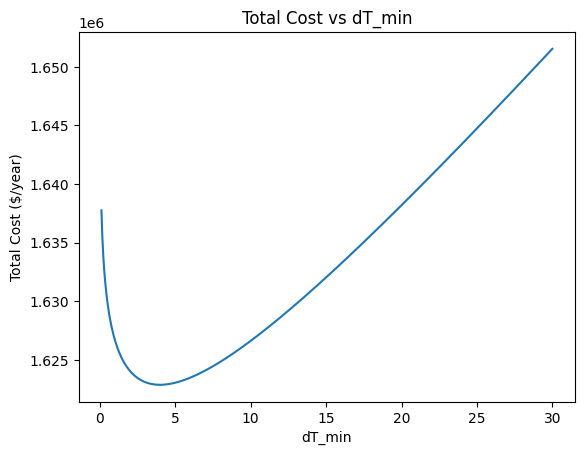

In [24]:
import matplotlib.pyplot as plt

def total_cost(dT):
    # Data
    df = pd.read_excel("heatForPython.xlsx")

    data_frame_cold = df[df['H/C'].str.contains('C')]
    data_frame_hot = df[df['H/C'].str.contains('H')]

    #End Points
    def endPointMaker(data, type='C'):
        temperatures = pd.concat([data['Tin'], data['Tout']])
        unique_sorted_temperatures = np.sort(temperatures.unique())
        dataFrame = pd.DataFrame(unique_sorted_temperatures, columns=[f'{type} end Points'])
        return dataFrame

    cold_end_point = endPointMaker(data_frame_cold, 'C')
    hot_end_point = endPointMaker(data_frame_hot, 'H')

    '''Pseudo end points'''
    pseudo_cold_end_points= cold_end_point + dT/2
    pseudo_hot_end_points= hot_end_point - dT/2


    def mergeAndSortEndpoints(cold_end_points, hot_end_points):
        merged = pd.concat([cold_end_points, hot_end_points]).reset_index(drop=True)
        merged = merged.drop_duplicates().sort_values(by=merged.columns[0]).reset_index(drop=True)
        combined_temperatures = pd.concat([merged['C end Points'], merged['H end Points']]).dropna()
        unique_sorted_temperatures = combined_temperatures.drop_duplicates().sort_values(ascending=False).reset_index(drop=True)
        return unique_sorted_temperatures

    '''Total End Points'''
    total_end_points = mergeAndSortEndpoints(cold_end_point, hot_end_point)
    '''Pseudo Total End Points'''
    total_pseudo_end_points = mergeAndSortEndpoints(pseudo_cold_end_points, pseudo_hot_end_points)

    # Phase change end point check
    def check_phase_change(df, temperature_list):
        # temperature_list'teki tüm değerleri float'a dönüştür
        temperature_list = [float(temp) for temp in temperature_list]  
        # 'phase change' değeri NaN olmayan satırları filtrele
        filtered_df = df.dropna(subset=['phase change'])
        # Filtrelenmiş satırları döngüye al
        for index, row in filtered_df.iterrows():
            tin = float(row['Tin'])
            tout = float(row['Tout'])        
            # Her iki değerin de listede olup olmadığını kontrol et
            if tin in temperature_list and tout in temperature_list:
                tin_index = temperature_list.index(tin)
                tout_index = temperature_list.index(tout)
            
                # Tin ve Tout'un listede sıralı olup olmadığını kontrol et
                if abs(tin_index - tout_index) == 1:
                    return True 
                else:
                    print(f"Tin ({tin}) ve Tout ({tout}) listede yan yana değil.")
            else:
                return False


    # Pinch Point,  Hot and Cold  Utulity
    # Data frame'e pseudo sıcaklıkları ekleme

    df['Pseudo Tin'] = df.apply(lambda row: row['Tin'] + dT/2 if 'C' in row['H/C'] else row['Tin'] - dT/2, axis=1)
    df['Pseudo Tout'] = df.apply(lambda row: row['Tout'] + dT/2 if 'C' in row['H/C'] else row['Tout'] - dT/2, axis=1)


    intervals = zip(total_pseudo_end_points, total_pseudo_end_points[1:])

    negative_dH = []

    # Aralıklar üzerinde döngü
    for upper, lower in intervals:
        '''ARALIKLAR'''
        # Mask kullanarak DataFrame'den verileri filtreleme
        # 'H' ile başlayanlar için mask
        mask_H = ((df['H/C'].str.startswith('H')) &
                ((df['Pseudo Tin'] >= upper) & (df['Pseudo Tout'] <= lower)))

        # 'C' ile başlayanlar için mask
        mask_C = ((df['H/C'].str.startswith('C')) &
                ((df['Pseudo Tin'] <= lower) & (df['Pseudo Tout'] >= upper)))

        # 'H' ile başlayanlar için seçilen akımlar
        selected_streams_H = df[mask_H]

        # 'C' ile başlayanlar için seçilen akımlar
        selected_streams_C = df[mask_C]
        selected_streams = pd.concat([selected_streams_H, selected_streams_C], ignore_index=True)

        '''-dH BULMAK İÇİN'''
        total_energy = 0
        for _, stream in selected_streams.iterrows():
            if stream['H/C'].startswith('H'):
                if pd.notna(stream['phase change']):
                    total_energy += stream['q (kj/s)']
                else:
                    total_energy += stream['nCp (kJ/s-K)'] * (upper - lower)
            else: 
                if pd.notna(stream['phase change']):
                    total_energy -= stream['q (kj/s)']
                else:
                    total_energy -= stream['nCp (kJ/s-K)'] * (upper - lower)
        negative_dH.append(total_energy)


    cumulative_energy_list= []
    energy_start=0
    for energy in negative_dH:
        energy_start += energy
        cumulative_energy_list.append(energy_start)

    min_hot_utulity= -min(cumulative_energy_list)


    cumulative_energy_list_start_with_hot_utility = []
    cumulative_energy_list_start_with_hot_utility.append(min_hot_utulity)
    energy_start=min_hot_utulity
    for energy in negative_dH:
        energy_start += energy
        cumulative_energy_list_start_with_hot_utility.append(energy_start)

    min_cold_utulity= cumulative_energy_list_start_with_hot_utility[-1]


    '''/////  Pinch Points /////'''
    # pinch point for hot
    pinch_indeks = np.abs(cumulative_energy_list_start_with_hot_utility).argmin()
    hot_pinch = total_pseudo_end_points [pinch_indeks] + dT/2
    # pinch point for cold
    cold_pinch = total_pseudo_end_points [pinch_indeks] - dT/2


    #print(f'Cold: Pinch : {cold_pinch}')
    #print(f'hot_pinch {hot_pinch}')

    '''HEN system'''
    split_fraction = 0.7

    exchanger_data = {
        'Heat exchanger' :  ["H1-C1", "H1-CU", "H2-CU", "H3-CU", "H2-C1/1", "H3-C1/2", "C1-HU", "C2-HU"],
        "H": ["H1", "H1", "H2", "H3", "H2", "H3","fh", "hps" ],
        "C": ["C1", "cw", "cw", "cw", "C1/1", "C1/2", "C1", "C2"],
        "nCp(h)": [float(df[df['H/C'].str.contains('H1')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H1')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H2')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H3')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H2')]['nCp (kJ/s-K)']), float(df[df['H/C'].str.contains('H3')]['nCp (kJ/s-K)']), np.nan, np.nan],
        "nCp (c)": [float(df[df['H/C'].str.contains('C1')]['nCp (kJ/s-K)']) , np.nan, np.nan, np.nan, float(df[df['H/C'].str.contains('C1')]['nCp (kJ/s-K)']) *split_fraction , float(df[df['H/C'].str.contains('C1')]['nCp (kJ/s-K)']) * (1- split_fraction) , float(df[df['H/C'].str.contains('C1')]['nCp (kJ/s-K)']) , np.nan],
        "T(h,in)": [hot_pinch, 'a' , hot_pinch, hot_pinch, float(df[df['H/C'].str.contains('H2')]['Tin']), float(df[df['H/C'].str.contains('H3')]['Tin']), 450, 370],
        "T(h,out)": ["a", float(df[df['H/C'].str.contains('H1')]['Tout']), float(df[df['H/C'].str.contains('H2')]['Tout']), float(df[df['H/C'].str.contains('H3')]['Tout']), hot_pinch,  hot_pinch, 350, 350],
        "T(c,in)": [float(df[df['H/C'].str.contains('C1')]['Tin']), 20, 20, 20, cold_pinch, cold_pinch, "#DEĞER!", float(df[df['H/C'].str.contains('C2')]['Tin'])],
        "T(c,out)": [cold_pinch, 45, 40, 30, "b", "c", float(df[df['H/C'].str.contains('C1')]['Tout']), float(df[df['H/C'].str.contains('C2')]['Tout'])],
        "Q": ["q1", "q2", "q3", "q4", "q5", "q6", "q7", float(df[df['H/C'].str.contains('C2')]['q (kj/s)'])],
        'U' : [ (((427.8+2713.2)/(2*3600)) ),(((2713.2+13500)/(2*3600))) , (((1085.5+13500)/(2*3600))) , (((427.8+ 13500)/(2*3600)))  ,(((1085.5+2713.2)/(2*3600))) ,((( 427.8+2713.2)/(2*3600))) , (((2713.2+ 399.6)/(2*3600))) , (((775.8+21600)/(2*3600)))  ]
    }

    ''' Eksik dataların girişi'''
    exchanger_data['Q'][0] = (exchanger_data['T(c,out)'][0]  - exchanger_data['T(c,in)'][0]) * exchanger_data['nCp (c)'][0]
    exchanger_data['T(h,out)'][0] = (- exchanger_data['Q'][0])/ exchanger_data['nCp(h)'][0] + exchanger_data['T(h,in)'][0]
    exchanger_data['T(h,in)'][1]  = exchanger_data['T(h,out)'][0]
    exchanger_data['Q'][1] =  (exchanger_data['T(h,in)'][1]  - exchanger_data['T(h,out)'][1]) * exchanger_data['nCp(h)'][1]
    exchanger_data['Q'][2] = (exchanger_data['T(h,in)'][2]  - exchanger_data['T(h,out)'][2]) * exchanger_data['nCp(h)'][2]
    exchanger_data['Q'][3] = (exchanger_data['T(h,in)'][3]  - exchanger_data['T(h,out)'][3]) * exchanger_data['nCp(h)'][3]
    exchanger_data['Q'][4] = (exchanger_data['T(h,in)'][4]  - exchanger_data['T(h,out)'][4]) * exchanger_data['nCp(h)'][4]
    exchanger_data['T(c,out)'][4] = exchanger_data['Q'][4] / exchanger_data['nCp (c)'][4]  + exchanger_data['T(c,in)'][4]
    exchanger_data['Q'][5] = (exchanger_data['T(h,in)'][5]  - exchanger_data['T(h,out)'][5]) * exchanger_data['nCp(h)'][5]
    exchanger_data['T(c,out)'][5] = exchanger_data['Q'][5] / exchanger_data['nCp (c)'][5]  + exchanger_data['T(c,in)'][5]
    exchanger_data['T(c,in)'][6] = exchanger_data['T(c,out)'][4] * split_fraction + exchanger_data['T(c,out)'][5]* (1- split_fraction)
    exchanger_data['Q'][6] = (exchanger_data['T(c,out)'][6]  - exchanger_data['T(c,in)'][6]) * exchanger_data['nCp (c)'][6]

    exchanger_dataFrame = pd.DataFrame(exchanger_data)

    # dTlm sütununu hesapla ve veri çerçevesine ekle
    exchanger_dataFrame['dTlm'] = ((exchanger_dataFrame['T(h,in)'] - exchanger_dataFrame['T(c,out)']) - (exchanger_dataFrame['T(h,out)'] - exchanger_dataFrame['T(c,in)'])) / \
                (np.log((exchanger_dataFrame['T(h,in)'] - exchanger_dataFrame['T(c,out)']) / (exchanger_dataFrame['T(h,out)'] - exchanger_dataFrame['T(c,in)'])))
    exchanger_dataFrame['Area (m2)'] = exchanger_dataFrame['Q'] / (exchanger_dataFrame['U'] * exchanger_dataFrame['dTlm'])
    exchanger_dataFrame['Utility cp (kj/kgC)'] = pd.DataFrame([np.nan, 4.184, 4.184, 4.184 ,np.nan , np.nan , 1 , 1703 ])
    exchanger_dataFrame['Utility Flowrate (kg/h)'] = pd.DataFrame([ np.nan, 
                                                                (exchanger_dataFrame['Q'][1]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][1] * (exchanger_dataFrame['T(c,out)'][1]- exchanger_dataFrame['T(c,in)'][1])))*3600, 
                                                                (exchanger_dataFrame['Q'][2]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][2] * (exchanger_dataFrame['T(c,out)'][2]- exchanger_dataFrame['T(c,in)'][2])))*3600, 
                                                                (exchanger_dataFrame['Q'][3]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][3] * (exchanger_dataFrame['T(c,out)'][3]- exchanger_dataFrame['T(c,in)'][3])))*3600,
                                                                np.nan ,
                                                                np.nan , 
                                                                (exchanger_dataFrame['Q'][6]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][6] * (exchanger_dataFrame['T(h,in)'][6]- exchanger_dataFrame['T(h,out)'][6])))*3600, 
                                                                (exchanger_dataFrame['Q'][7]/ (exchanger_dataFrame['Utility cp (kj/kgC)'][7] * (exchanger_dataFrame['T(h,in)'][7]- exchanger_dataFrame['T(h,out)'][7])))*3600])

    cpi = 1.85
    life_time = 20 #year

    exchanger_dataFrame['Area cost ($/year)'] = ( (exchanger_dataFrame['Area (m2)'] ** 0.6) * (3* 10**3)* cpi ) / life_time

    cw_unit_cost = (0.08/1000)* cpi #  $/kg 
    fh_unit_cost = (0.35/(10**6))*cpi # $/kj
    hps_unit_cost = (4.4/1000) * cpi # $/kg
    
    exchanger_dataFrame['Utility Cost ($/Year)'] = pd.DataFrame([0,
                                                                exchanger_dataFrame['Utility Flowrate (kg/h)'][1]* cw_unit_cost*24*365,
                                                                exchanger_dataFrame['Utility Flowrate (kg/h)'][2]* cw_unit_cost*24*365,
                                                                exchanger_dataFrame['Utility Flowrate (kg/h)'][3]* cw_unit_cost*24*365,
                                                                0,
                                                                0,
                                                                exchanger_dataFrame['Q'][6]* fh_unit_cost * 3600*24*365,
                                                                exchanger_dataFrame['Utility Flowrate (kg/h)'][7]* hps_unit_cost*24*365])




    exchanger_dataFrame['Total Cost'] = exchanger_dataFrame['Area cost ($/year)'] + exchanger_dataFrame['Utility Cost ($/Year)']
    grand_total = sum(exchanger_dataFrame['Total Cost'])


    return grand_total


# dT değerlerini oluştur
dT_values = np.linspace(0.1, 30, 1000)  # 10 ile 30 arasında 100 adet değer

# Her bir dT için total_cost fonksiyonunu çağır ve sonuçları bir listeye kaydet
results = [total_cost(dT) for dT in dT_values]

print ( f'Optimum dT_min value is : {round(dT_values[np.argmin(results)],1)} degree Celsius.')
print ( f'Total annualized cost corresponding to that dT_min value is : {round(min(results)/1000000, 2)} M$/year')


# Sonuçları grafik üzerinde çiz
plt.plot(dT_values, results)
plt.xlabel('dT_min')
plt.ylabel('Total Cost ($/year)')
plt.title('Total Cost vs dT_min')


# Future Work
Initially, the check_phase_change function is quite basic. Although it currently only indicates that there is no problem, it should offer solutions for situations that may cause problems in later stages.
In addition, instead of us setting a heat exchanger network system, the program could be designed to suggest a network to us. An example code for HEN estimation for below pinch is could be written as follows :

In [25]:
#Libraries that used
import pandas as pd
import numpy as np

# Data
df = pd.read_excel("heatForPython.xlsx")

data_frame_cold = df[df['H/C'].str.contains('C')]
data_frame_hot = df[df['H/C'].str.contains('H')]

#dT
dT = 30

#End Points
def endPointMaker(data, type='C'):
    temperatures = pd.concat([data['Tin'], data['Tout']])
    unique_sorted_temperatures = np.sort(temperatures.unique())
    dataFrame = pd.DataFrame(unique_sorted_temperatures, columns=[f'{type} end Points'])
    return dataFrame

cold_end_point = endPointMaker(data_frame_cold, 'C')
hot_end_point = endPointMaker(data_frame_hot, 'H')

'''Pseudo end points'''
pseudo_cold_end_points= cold_end_point + dT/2
pseudo_hot_end_points= hot_end_point - dT/2


def mergeAndSortEndpoints(cold_end_points, hot_end_points):
    merged = pd.concat([cold_end_points, hot_end_points]).reset_index(drop=True)
    merged = merged.drop_duplicates().sort_values(by=merged.columns[0]).reset_index(drop=True)
    combined_temperatures = pd.concat([merged['C end Points'], merged['H end Points']]).dropna()
    unique_sorted_temperatures = combined_temperatures.drop_duplicates().sort_values(ascending=False).reset_index(drop=True)
    return unique_sorted_temperatures

'''Total End Points'''
total_end_points = mergeAndSortEndpoints(cold_end_point, hot_end_point)
'''Pseudo Total End Points'''
total_pseudo_end_points = mergeAndSortEndpoints(pseudo_cold_end_points, pseudo_hot_end_points)

# Phase change end point check
def check_phase_change(df, temperature_list):
    # temperature_list'teki tüm değerleri float'a dönüştür
    temperature_list = [float(temp) for temp in temperature_list]  
    # 'phase change' değeri NaN olmayan satırları filtrele
    filtered_df = df.dropna(subset=['phase change'])
    # Filtrelenmiş satırları döngüye al
    for index, row in filtered_df.iterrows():
        tin = float(row['Tin'])
        tout = float(row['Tout'])        
        # Her iki değerin de listede olup olmadığını kontrol et
        if tin in temperature_list and tout in temperature_list:
            tin_index = temperature_list.index(tin)
            tout_index = temperature_list.index(tout)
        
            # Tin ve Tout'un listede sıralı olup olmadığını kontrol et
            if abs(tin_index - tout_index) == 1:
                return True 
            else:
                print(f"Tin ({tin}) ve Tout ({tout}) listede yan yana değil.")
        else:
            return False


# Pinch Point,  Hot and Cold  Utulity
# Data frame'e pseudo sıcaklıkları ekleme

df['Pseudo Tin'] = df.apply(lambda row: row['Tin'] + dT/2 if 'C' in row['H/C'] else row['Tin'] - dT/2, axis=1)
df['Pseudo Tout'] = df.apply(lambda row: row['Tout'] + dT/2 if 'C' in row['H/C'] else row['Tout'] - dT/2, axis=1)


intervals = zip(total_pseudo_end_points, total_pseudo_end_points[1:])

negative_dH = []

# Aralıklar üzerinde döngü
for upper, lower in intervals:
    '''ARALIKLAR'''
    # Mask kullanarak DataFrame'den verileri filtreleme
    # 'H' ile başlayanlar için mask
    mask_H = ((df['H/C'].str.startswith('H')) &
            ((df['Pseudo Tin'] >= upper) & (df['Pseudo Tout'] <= lower)))

    # 'C' ile başlayanlar için mask
    mask_C = ((df['H/C'].str.startswith('C')) &
            ((df['Pseudo Tin'] <= lower) & (df['Pseudo Tout'] >= upper)))

    # 'H' ile başlayanlar için seçilen akımlar
    selected_streams_H = df[mask_H]

    # 'C' ile başlayanlar için seçilen akımlar
    selected_streams_C = df[mask_C]
    selected_streams = pd.concat([selected_streams_H, selected_streams_C], ignore_index=True)

    '''-dH BULMAK İÇİN'''
    total_energy = 0
    for _, stream in selected_streams.iterrows():
        if stream['H/C'].startswith('H'):
            if pd.notna(stream['phase change']):
                total_energy += stream['q (kj/s)']
            else:
                total_energy += stream['nCp (kJ/s-K)'] * (upper - lower)
        else: 
            if pd.notna(stream['phase change']):
                total_energy -= stream['q (kj/s)']
            else:
                total_energy -= stream['nCp (kJ/s-K)'] * (upper - lower)
    negative_dH.append(total_energy)


cumulative_energy_list= []
energy_start=0
for energy in negative_dH:
    energy_start += energy
    cumulative_energy_list.append(energy_start)

min_hot_utulity= -min(cumulative_energy_list)


cumulative_energy_list_start_with_hot_utility = []
cumulative_energy_list_start_with_hot_utility.append(min_hot_utulity)
energy_start=min_hot_utulity
for energy in negative_dH:
    energy_start += energy
    cumulative_energy_list_start_with_hot_utility.append(energy_start)

min_cold_utulity= cumulative_energy_list_start_with_hot_utility[-1]


'''/////  Pinch Points /////'''
# pinch point for hot
pinch_indeks = np.abs(cumulative_energy_list_start_with_hot_utility).argmin()
hot_pinch = total_pseudo_end_points [pinch_indeks] + dT/2
# pinch point for cold
cold_pinch = total_pseudo_end_points [pinch_indeks] - dT/2


def heat_exchanger(stream_hot , stream_cold , w):
        ok = True
        w= 1
        while ok:
            if w == 0:
                break
            Tc_out = w* below_energies[stream_cold] / 23.694636
            if Tc_out > dT:
                below_energies[stream_hot] += (w* below_energies[stream_cold])
                below_energies[stream_cold] -= (w* below_energies[stream_cold])
                print(f'{stream_cold} ile {stream_hot} arasında {w} katsayyısı ile çalışan heat exchanger.')
                ok = False
            w -=0.1
    

''' Hen '''

data_frame_cold = df[df['H/C'].str.contains('C')]
data_frame_hot = df[df['H/C'].str.contains('H')]


below_energies = dict()


for index, row_cold in data_frame_cold[['H/C', 'nCp (kJ/s-K)', 'Tin', 'Tout',  'q (kj/s)']].iterrows():
    for index1, row_hot in data_frame_hot[['H/C', 'nCp (kJ/s-K)','Tin', 'Tout', 'q (kj/s)']].iterrows():
        # Below pinch
        if (row_hot['Tout'] <  hot_pinch ) and  (row_cold['Tin'] < cold_pinch ):
            if row_hot['Tout'] <=  hot_pinch <= row_hot['Tin']:
                below_energies[row_hot['H/C']]= row_hot['nCp (kJ/s-K)'] * (row_hot['Tout']-hot_pinch)
            else:
                below_energies[row_hot['H/C']]= row_hot['nCp (kJ/s-K)'] * (row_hot['Tout']-row_hot['Tin'])
            if row_cold['Tin'] <= cold_pinch <= row_cold['Tout']:
                below_energies[row_cold['H/C']]= row_cold['nCp (kJ/s-K)'] * (row_cold['Tout']-cold_pinch)
            else:
                below_energies[row_cold['H/C']]= row_cold['nCp (kJ/s-K)'] * (row_cold['Tout']-row_cold['Tin'])

            print('BELOW', row_cold['H/C'], row_hot['H/C'])


for index, row_cold in data_frame_cold[['H/C', 'nCp (kJ/s-K)', 'Tin', 'Tout',  'q (kj/s)']].iterrows():
    for index1, row_hot in data_frame_hot[['H/C', 'nCp (kJ/s-K)','Tin', 'Tout', 'q (kj/s)']].iterrows():
        if (row_hot['Tout'] <  hot_pinch ) and  (row_cold['Tin'] < cold_pinch ):
            if (row_cold['nCp (kJ/s-K)'] < row_hot['nCp (kJ/s-K)']):
                    print(f'Heat exchanger can be setted between {row_cold["H/C"]} and {row_hot["H/C"]}')

heat_exchanger('H3', 'C1' , 1)

print(below_energies)

'''
for index, row_cold in data_frame_cold[['H/C', 'nCp (kJ/s-K)', 'Tin', 'Tout' ]].iterrows():
    for index1, row_hot in data_frame_hot[['H/C', 'nCp (kJ/s-K)','Tin', 'Tout']].iterrows():
        if (row_hot['Tin'] >  hot_pinch ) and  (row_cold['Tout'] > cold_pinch ):
            print('ABOVE', row_cold['H/C'], row_hot['H/C'])
            if (row_cold['nCp (kJ/s-K)'] > row_hot['nCp (kJ/s-K)']):
                print('evet') 
'''


# Above pinch

# Cost


BELOW C1 H1
BELOW C1 H2
BELOW C1 H3
Heat exchanger can be setted between C1 and H1
C1 ile H3 arasında 1 katsayyısı ile çalışan heat exchanger.
{'H1': -31693.452648067858, 'C1': 0.0, 'H2': -2081.427821140666, 'H3': 5503.353623796724}


"\nfor index, row_cold in data_frame_cold[['H/C', 'nCp (kJ/s-K)', 'Tin', 'Tout' ]].iterrows():\n    for index1, row_hot in data_frame_hot[['H/C', 'nCp (kJ/s-K)','Tin', 'Tout']].iterrows():\n        if (row_hot['Tin'] >  hot_pinch ) and  (row_cold['Tout'] > cold_pinch ):\n            print('ABOVE', row_cold['H/C'], row_hot['H/C'])\n            if (row_cold['nCp (kJ/s-K)'] > row_hot['nCp (kJ/s-K)']):\n                print('evet') \n"

Additionally, it is possible to optimize several different variables simultaneously, such as dT_min and utility temperatures. This is done using the minimize function from scipy.optimize. An example usage could be as follows:

In [26]:
from scipy.optimize import  minimize

def total_cost(params):
    dT_min = params[0]
    pass
    ...


initial_values = [ 2 , 25, 400]
bounds = [(0.1, 35), (15, 45), (300, 400 )]  
result = minimize(total_cost, initial_values, method='L-BFGS-B', bounds=bounds)
optimized_params = result.x  # Best parameter values
print(optimized_params)

TypeError: '<' not supported between instances of 'NoneType' and 'float'